In [2]:
# === Ignorar advertencias ===
import warnings
warnings.filterwarnings('ignore')

# === Manejo del sistema y utilidades ===
import os
import ast
from itertools import product
from tqdm import tqdm
import random

# === Manipulación de datos ===
import numpy as np
import pandas as pd

# === Visualización ===
import matplotlib.pyplot as plt

# === Preprocesamiento y métricas ===
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# === Diagnóstico estadístico ===
from statsmodels.stats.diagnostic import acorr_ljungbox

# === Redes neuronales (Keras / TensorFlow) ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
import tensorflow as tf


In [3]:
# Listar dispositivos disponibles
devices = tf.config.list_physical_devices('GPU')

if devices:
    print(f"TensorFlow está utilizando la GPU: {devices}")
else:
    print("TensorFlow no está utilizando la GPU")



TensorFlow está utilizando la GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Lectura de datos

In [4]:
df = pd.read_csv('./datasets/data_treino_dv_df_2000_2010.csv')
df.head(1)

,HORA (UTC),"VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))","VENTO, VELOCIDADE HORARIA (m/s)",UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C),TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C),"UMIDADE RELATIVA DO AR, HORARIA (%)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)","VENTO, RAJADA MAXIMA (m/s)",PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7


In [5]:
df.columns = ['HORA','WIND_DIR_HOR','WIND_VEL_HOR','HUM_REL_MAX_ANT','HUM_REL_MIN_ANT','TEMP_MAX_ANT','TEMP_MIN_ANT','HUM_REL_HOR','PRES_ATM_NIV','PREC_HOR','RAFAGA_VIENTO','PRES_ATM_MAX_ANT','PRES_ATM_MIN_ANT']
df.head(2)

,HORA,WIND_DIR_HOR,WIND_VEL_HOR,HUM_REL_MAX_ANT,HUM_REL_MIN_ANT,TEMP_MAX_ANT,TEMP_MIN_ANT,HUM_REL_HOR,PRES_ATM_NIV,PREC_HOR,RAFAGA_VIENTO,PRES_ATM_MAX_ANT,PRES_ATM_MIN_ANT
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,55.0,888.4,0.0,4.7,888.4,888.2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87693 entries, 0 to 87692
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HORA              87693 non-null  object 
 1   WIND_DIR_HOR      87693 non-null  float64
 2   WIND_VEL_HOR      87693 non-null  float64
 3   HUM_REL_MAX_ANT   87693 non-null  float64
 4   HUM_REL_MIN_ANT   87693 non-null  float64
 5   TEMP_MAX_ANT      87693 non-null  float64
 6   TEMP_MIN_ANT      87693 non-null  float64
 7   HUM_REL_HOR       87693 non-null  float64
 8   PRES_ATM_NIV      87693 non-null  float64
 9   PREC_HOR          87693 non-null  float64
 10  RAFAGA_VIENTO     87693 non-null  float64
 11  PRES_ATM_MAX_ANT  87693 non-null  float64
 12  PRES_ATM_MIN_ANT  87693 non-null  float64
dtypes: float64(12), object(1)
memory usage: 8.7+ MB


In [7]:
df.drop(columns='HORA', inplace= True)

## Prueba de Modelos ANN

A continuación se realizan pruebas individuales de los modelos MLP, RNN y LSTM para obtener una idea de que parametros se ajustan mejor al problema. Posteriormente, por medio de un search más extensivo se buscara los parametros que ofrezcan mejores resultados.

### LSTM

In [ ]:
# 🧠 Genera secuencias de entrenamiento para RNN y LSTM
def create_sequences(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq = df.iloc[i:i+window_size]
        X.append(seq.drop(columns=[target_col]).values)
        y.append(df.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

# Simulación de datos
data = {
    'feature_1': [10, 11, 12, 13, 14, 15],
    'feature_2': [20, 21, 22, 23, 24, 25],
    'target':     [1,  2,  3,  4,  5,  6]
}
df = pd.DataFrame(data)
X, y = create_sequences(df, target_col='target', window_size=3)
X

[array([[10, 20],
        [11, 21],
        [12, 22]], dtype=int64),
 array([[11, 21],
        [12, 22],
        [13, 23]], dtype=int64),
 array([[12, 22],
        [13, 23],
        [14, 24]], dtype=int64)]

In [15]:
y

[4, 5, 6]

#### Ventana de 7 dias

1/1 [==============================] - 0s 230ms/step


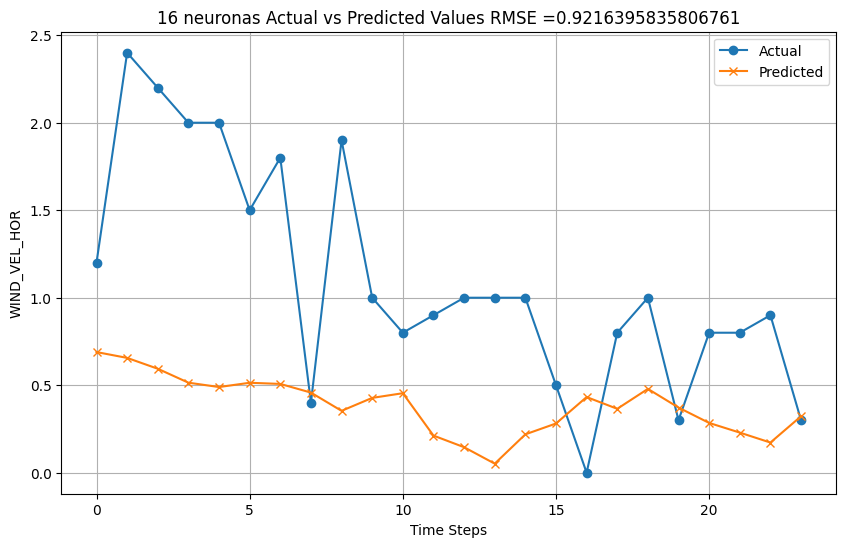

1/1 [==============================] - 0s 188ms/step


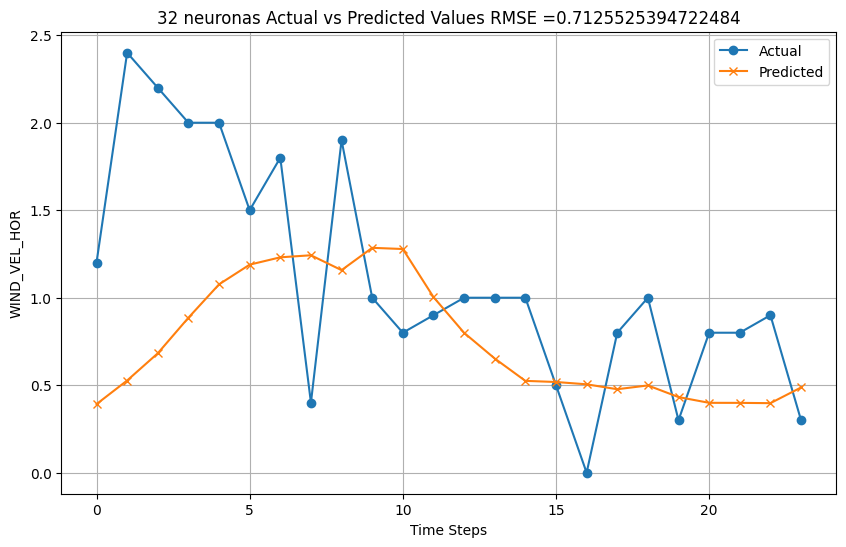

1/1 [==============================] - 0s 150ms/step


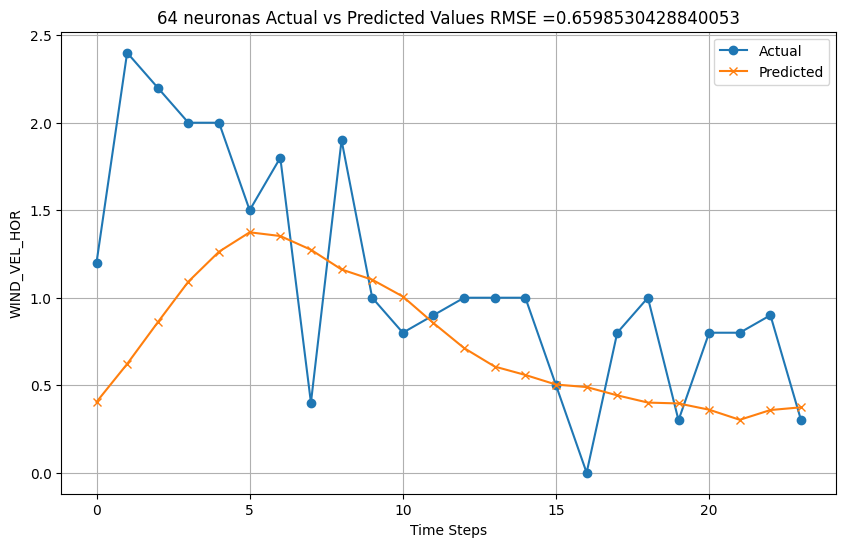

1/1 [==============================] - 0s 354ms/step


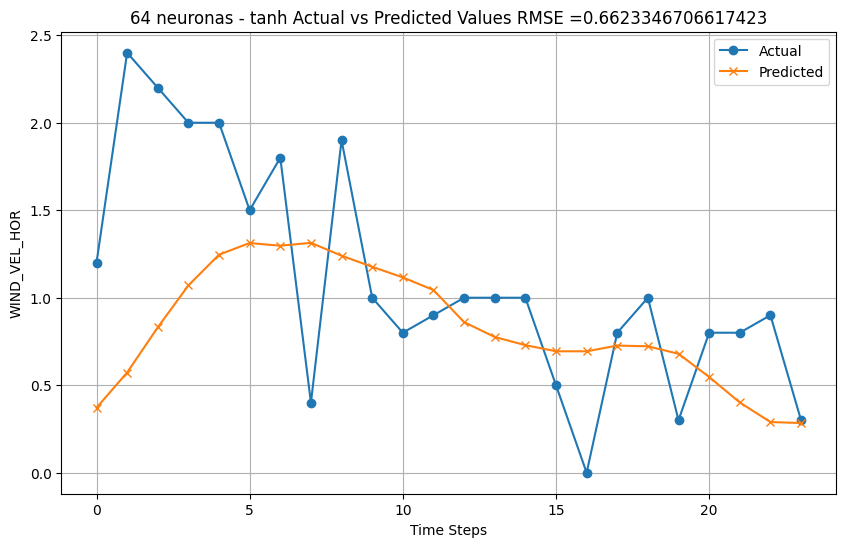

1/1 [==============================] - 0s 327ms/step


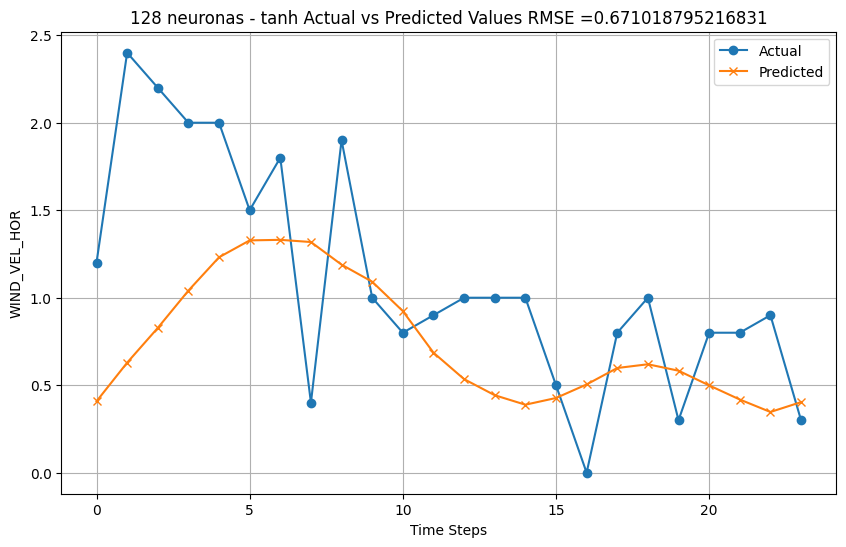

1/1 [==============================] - 0s 389ms/step


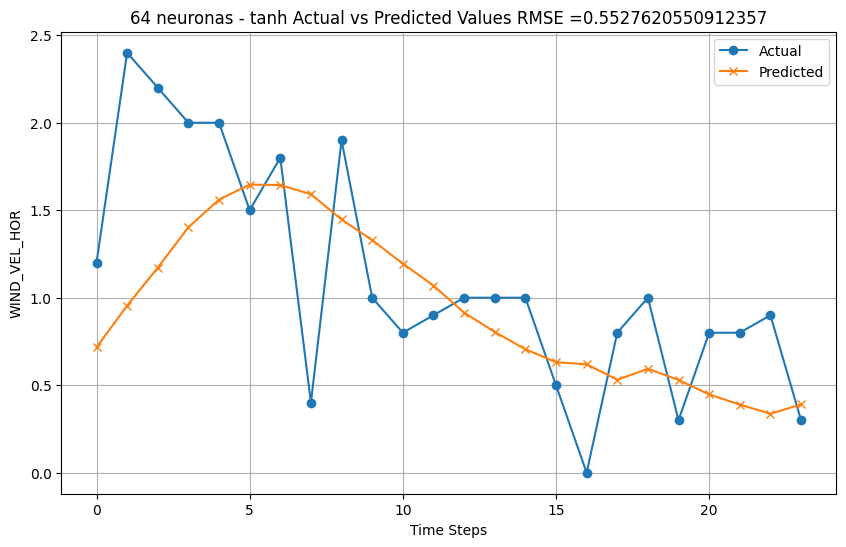

In [ ]:
# 🌱 Fijar todas las semillas necesarias
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

target_col = 'WIND_VEL_HOR'
window = 7
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24
extra = 1 * 24 # Datos adicionales para el testeo

data_window = df.iloc[start: start + T_hours + test_hours + extra].copy()
train_data = data_window.iloc[:T_hours]
test_data = data_window.iloc[T_hours:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data.drop(columns=[target_col]))
X_test_scaled = scaler.fit_transform(test_data.drop(columns=[target_col]))

train_scaled = pd.DataFrame(X_train_scaled, columns=train_data.columns.drop(target_col))
train_scaled[target_col] = train_data[target_col].values
test_scaled = pd.DataFrame(X_test_scaled, columns=test_data.columns.drop(target_col))
test_scaled[target_col] = test_data[target_col].values
scaled = pd.concat([train_scaled, test_scaled])

X, y = create_sequences(scaled, target_col, T_hours)
# (n_samples, timesteps, n_features)
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

## Capa e 16 neuronas

model =  Sequential([
  LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'16 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 32 neuronas

model =  Sequential([
  LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'32 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas

model =  Sequential([
  LSTM(64, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas y tanh

model =  Sequential([
  LSTM(64, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - tanh Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 128 neuronas y tanh

model =  Sequential([
  LSTM(128, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'128 neuronas - tanh Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas y tanh - dropout

model =  Sequential([
  LSTM(64, return_sequences=False, activation='tanh', dropout= 0.1  , input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - tanh - dropout Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()


#### 14 dias

1/1 [==============================] - 0s 409ms/step


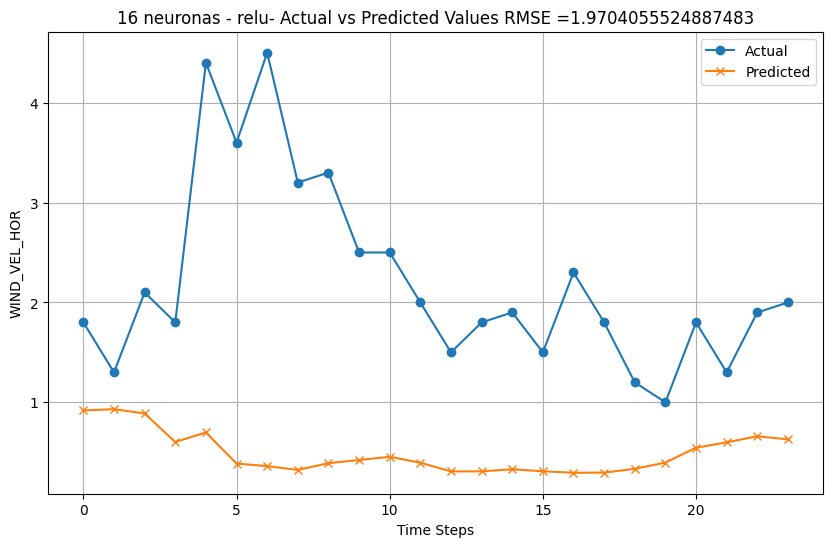

1/1 [==============================] - 0s 188ms/step


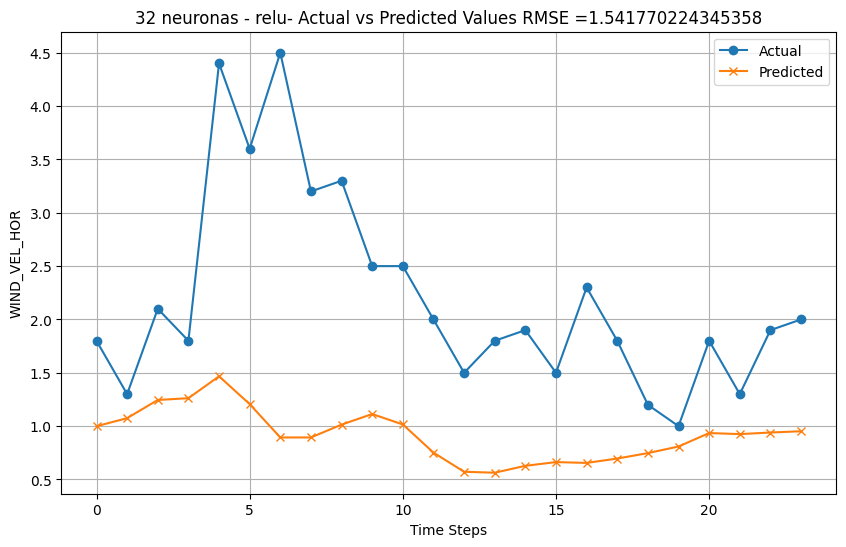

1/1 [==============================] - 0s 196ms/step


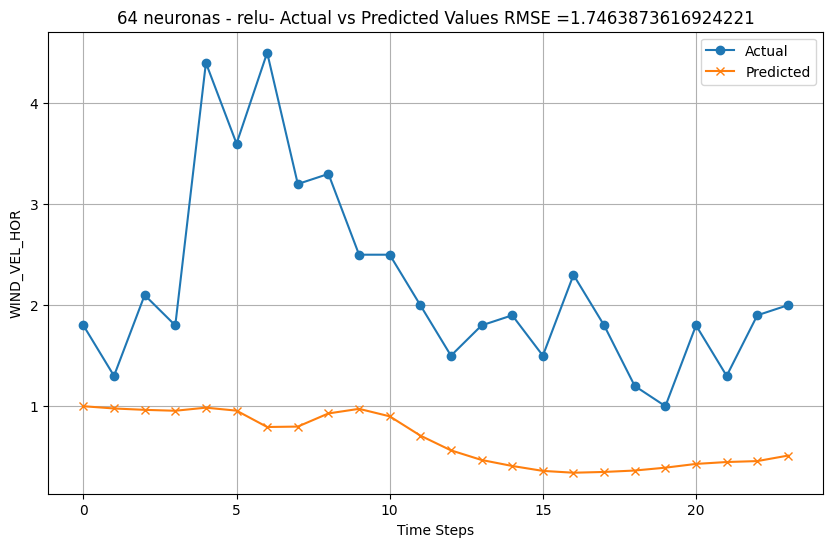

1/1 [==============================] - 0s 323ms/step


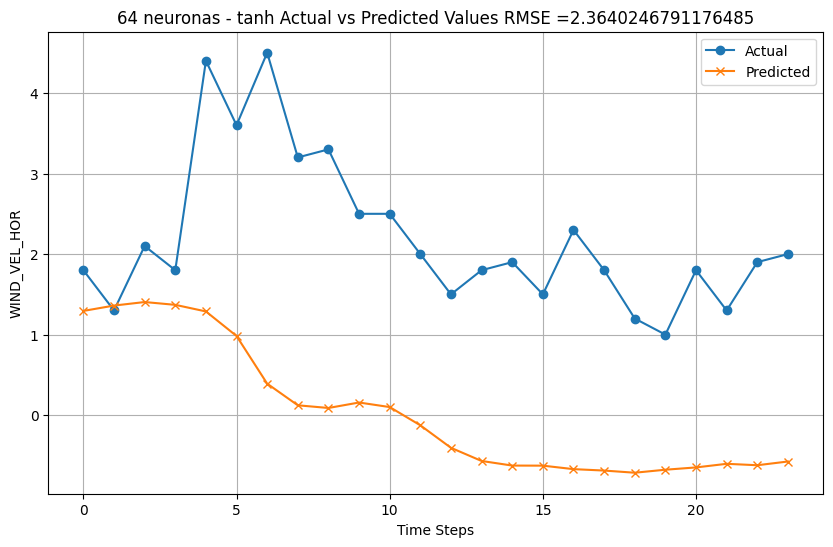

1/1 [==============================] - 0s 286ms/step


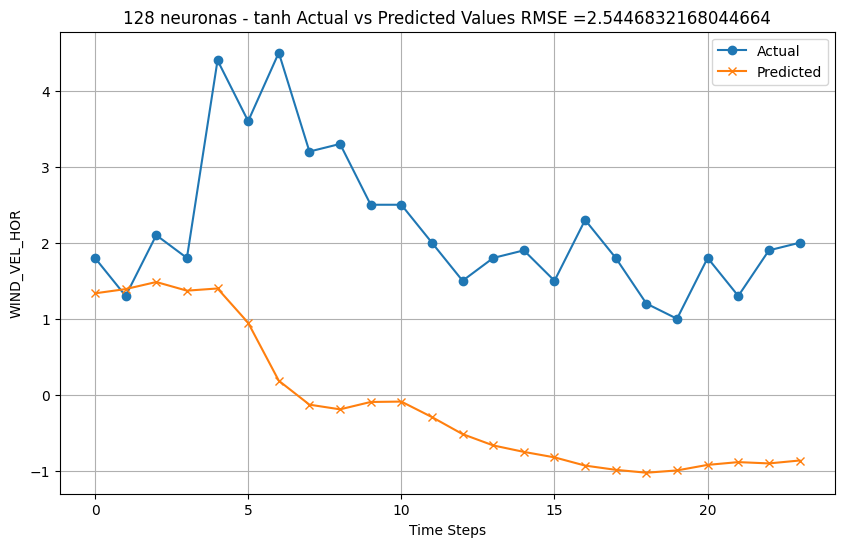

1/1 [==============================] - 0s 393ms/step


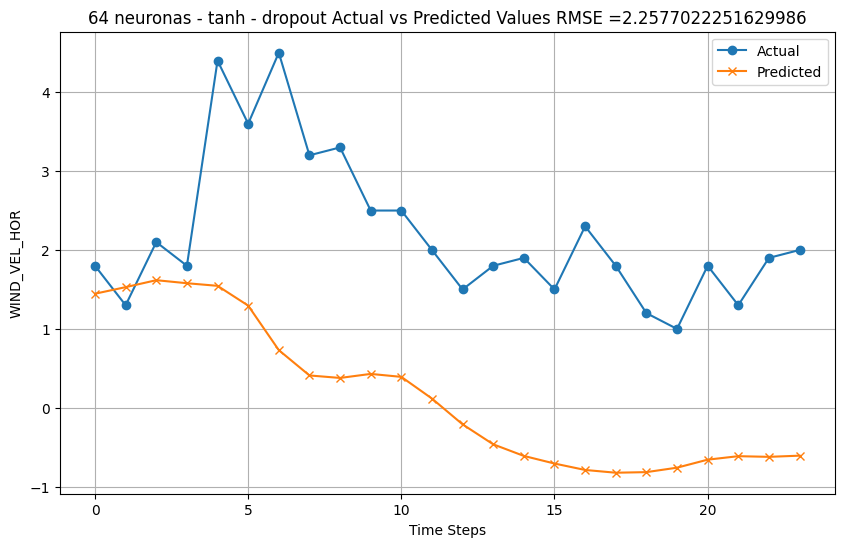

In [17]:
# 🌱 Fijar todas las semillas necesarias
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

target_col = 'WIND_VEL_HOR'
window = 14
start = 500 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24
extra = 1 * 24 # Datos adicionales para el testeo

data_window = df.iloc[start: start + T_hours + test_hours + extra].copy()
train_data = data_window.iloc[:T_hours]
test_data = data_window.iloc[T_hours:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data.drop(columns=[target_col]))
X_test_scaled = scaler.fit_transform(test_data.drop(columns=[target_col]))

train_scaled = pd.DataFrame(X_train_scaled, columns=train_data.columns.drop(target_col))
train_scaled[target_col] = train_data[target_col].values
test_scaled = pd.DataFrame(X_test_scaled, columns=test_data.columns.drop(target_col))
test_scaled[target_col] = test_data[target_col].values
scaled = pd.concat([train_scaled, test_scaled])

X, y = create_rnn_sequences(scaled, target_col, T_hours)
# (n_samples, timesteps, n_features)
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

## Capa e 16 neuronas

model =  Sequential([
  LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'16 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 32 neuronas

model =  Sequential([
  LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'32 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas

model =  Sequential([
  LSTM(64, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas y tanh

model =  Sequential([
  LSTM(64, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - tanh Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 128 neuronas y tanh

model =  Sequential([
  LSTM(128, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'128 neuronas - tanh Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas y tanh - dropout

model =  Sequential([
  LSTM(64, return_sequences=False, activation='tanh', dropout= 0.1  , input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - tanh - dropout Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()


#### 21 dias

1/1 [==============================] - 0s 230ms/step


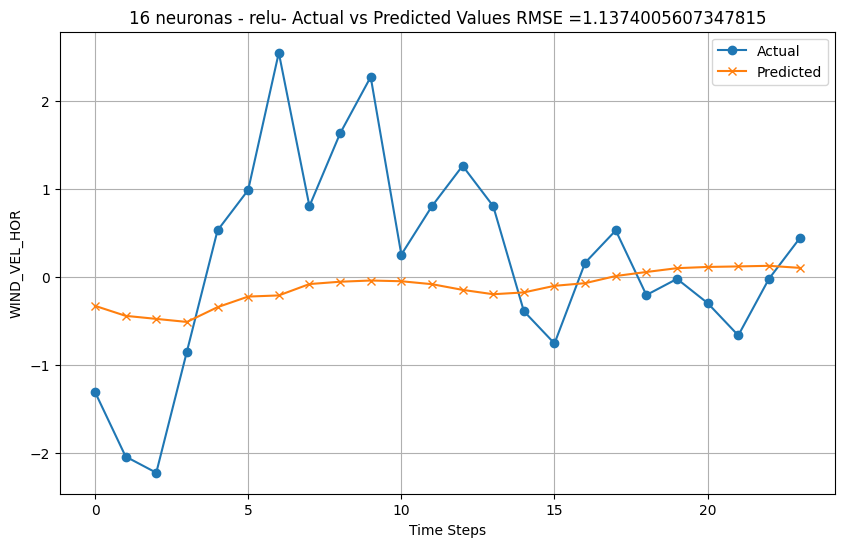

1/1 [==============================] - 0s 232ms/step


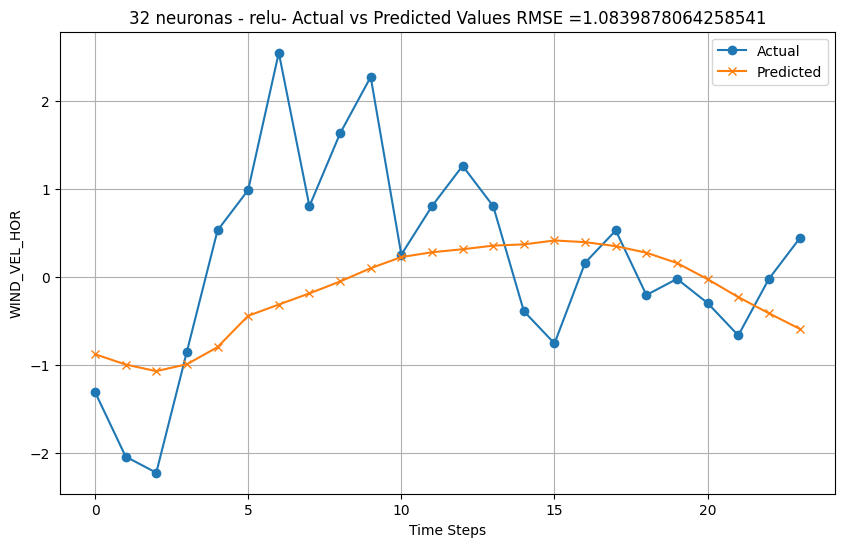

1/1 [==============================] - 0s 238ms/step


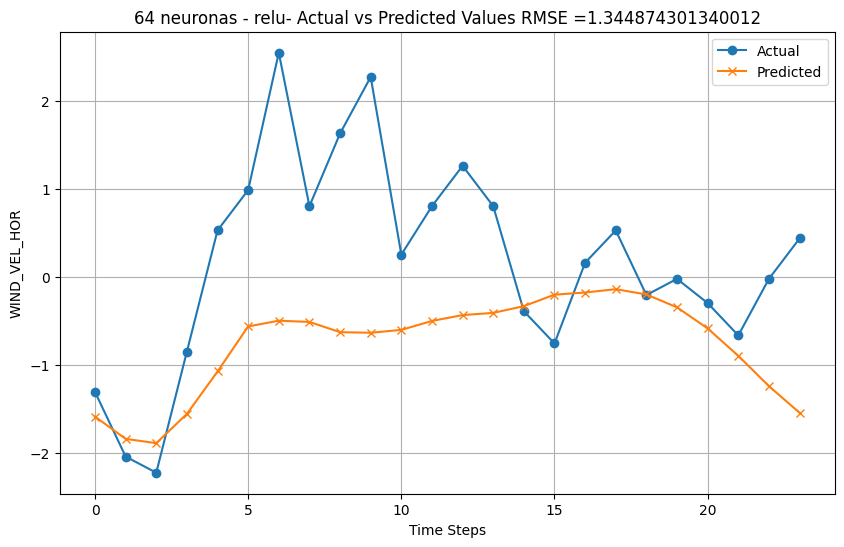

1/1 [==============================] - 0s 363ms/step


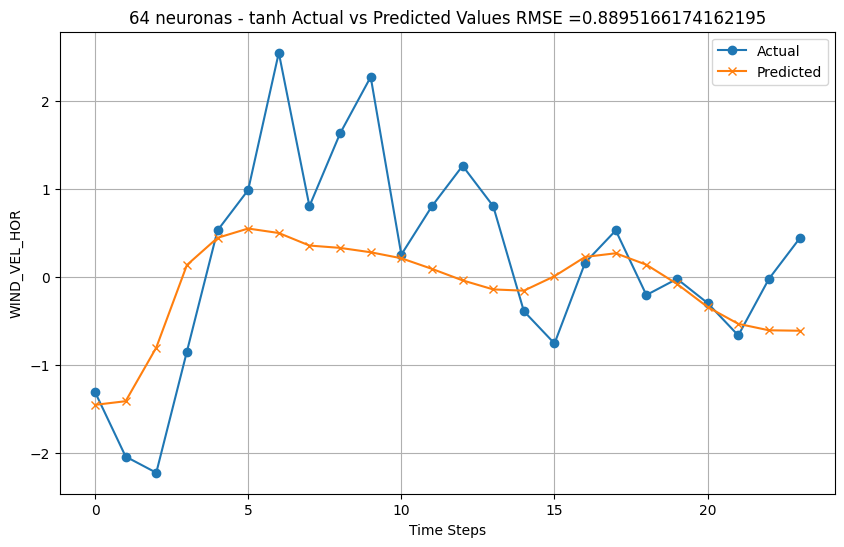

1/1 [==============================] - 0s 452ms/step


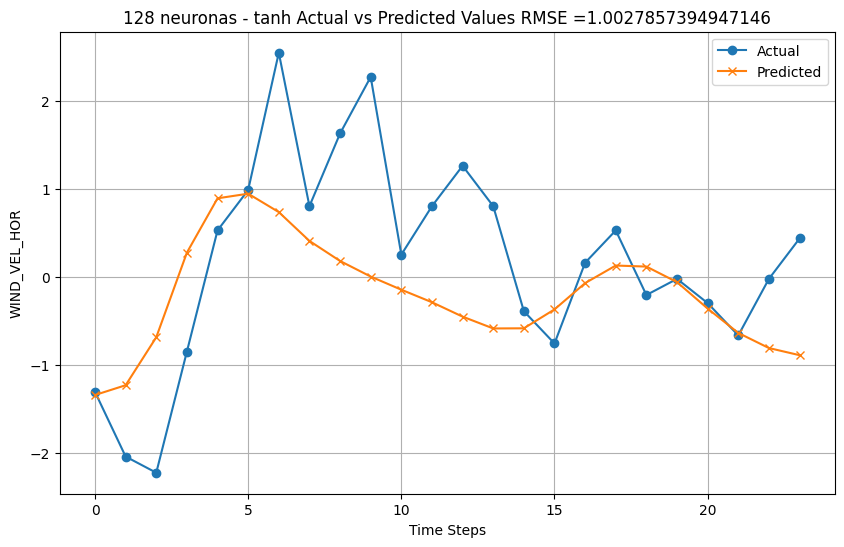

1/1 [==============================] - 0s 403ms/step


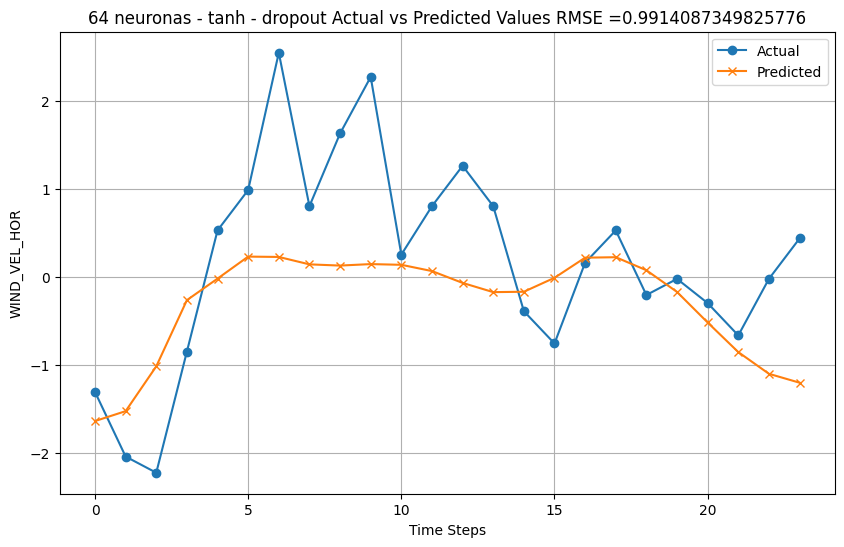

In [21]:
# 🌱 Fijar todas las semillas necesarias
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

target_col = 'WIND_VEL_HOR'
window = 21
start = 1 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24
extra = 1 * 24 # Datos adicionales para el testeo

data_window = df.iloc[start: start + T_hours + test_hours + extra].copy()
train_data = data_window.iloc[:T_hours]
test_data = data_window.iloc[T_hours:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data)
X_test_scaled = scaler.fit_transform(test_data)

train_scaled = pd.DataFrame(X_train_scaled, columns=train_data.columns)
#train_scaled[target_col] = train_data[target_col].values
test_scaled = pd.DataFrame(X_test_scaled, columns=test_data.columns)
#test_scaled[target_col] = test_data[target_col].values
scaled = pd.concat([train_scaled, test_scaled])

X, y = create_rnn_sequences(scaled, target_col, T_hours)
# (n_samples, timesteps, n_features)
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

## Capa e 16 neuronas

model =  Sequential([
  LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'16 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 32 neuronas

model =  Sequential([
  LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'32 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas

model =  Sequential([
  LSTM(64, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - relu- Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas y tanh

model =  Sequential([
  LSTM(64, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - tanh Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 128 neuronas y tanh

model =  Sequential([
  LSTM(128, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'128 neuronas - tanh Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Capa de 64 neuronas y tanh - dropout

model =  Sequential([
  LSTM(64, return_sequences=False, activation='tanh', dropout= 0.1  , input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'64 neuronas - tanh - dropout Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()


### MLP

#### Ventana de tiempo 7 días

1/1 [==============================] - 0s 47ms/step


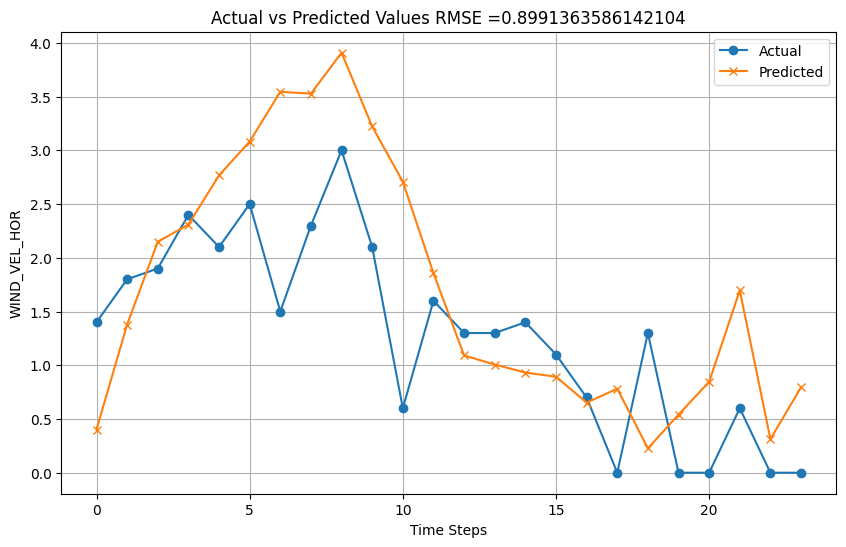

1/1 [==============================] - 0s 36ms/step


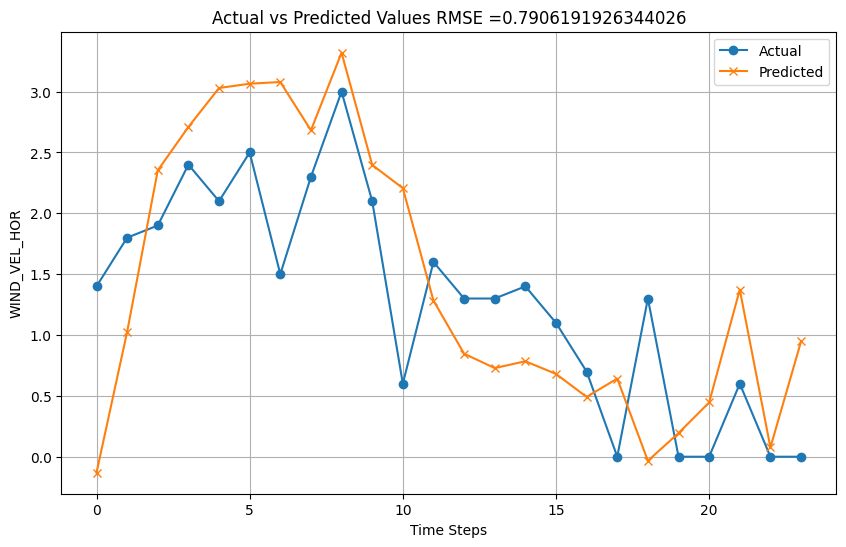

1/1 [==============================] - 0s 44ms/step


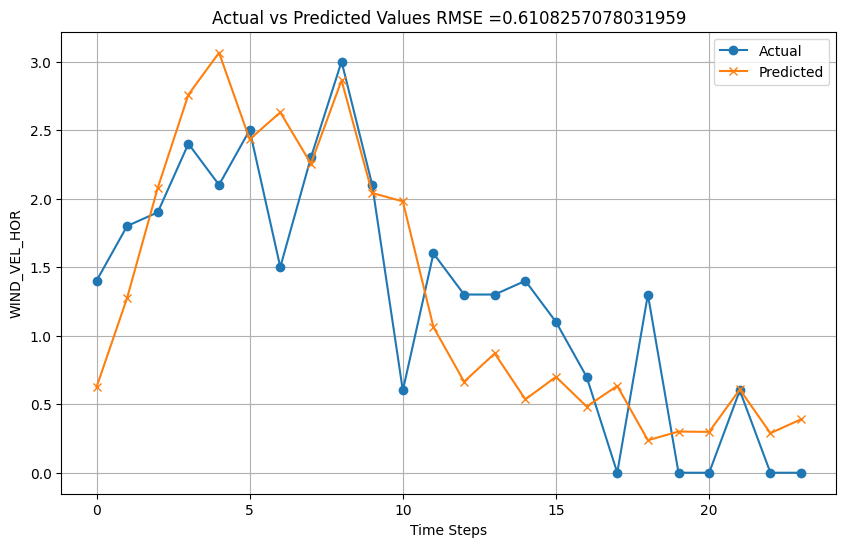

1/1 [==============================] - 0s 51ms/step


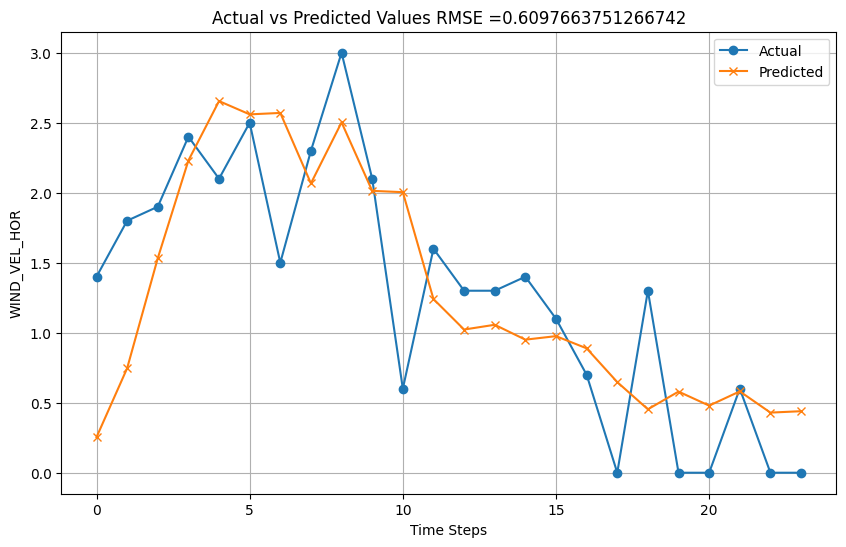

1/1 [==============================] - 0s 294ms/step


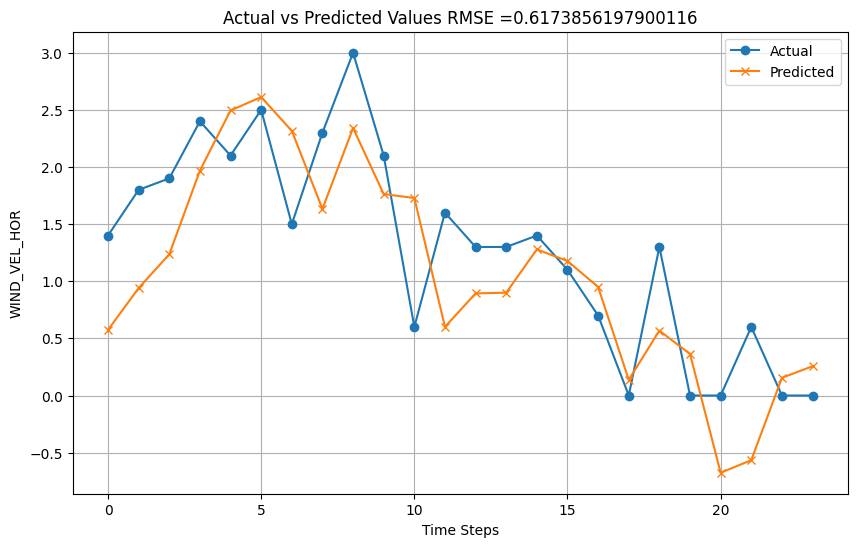

1/1 [==============================] - 0s 56ms/step


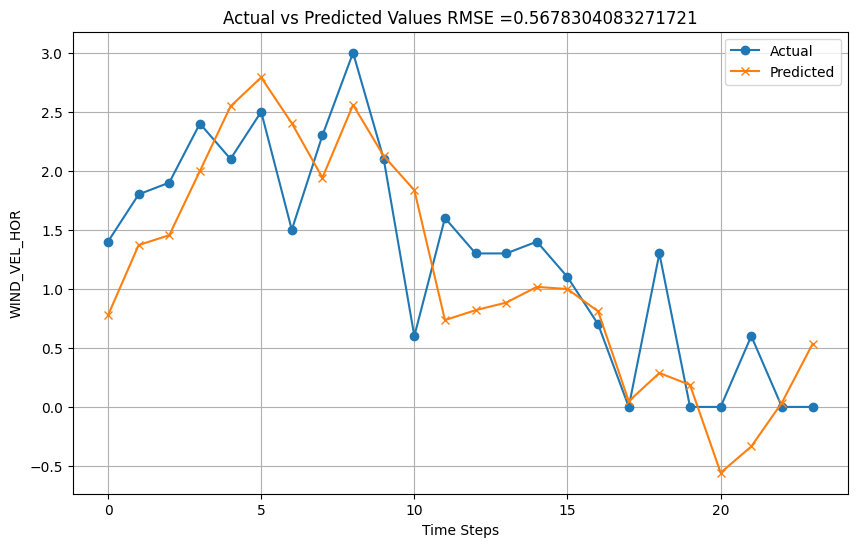

In [9]:
target_col = 'WIND_VEL_HOR'
window = 7
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

#### Ventana de tiempo 14 días

1/1 [==============================] - 0s 44ms/step


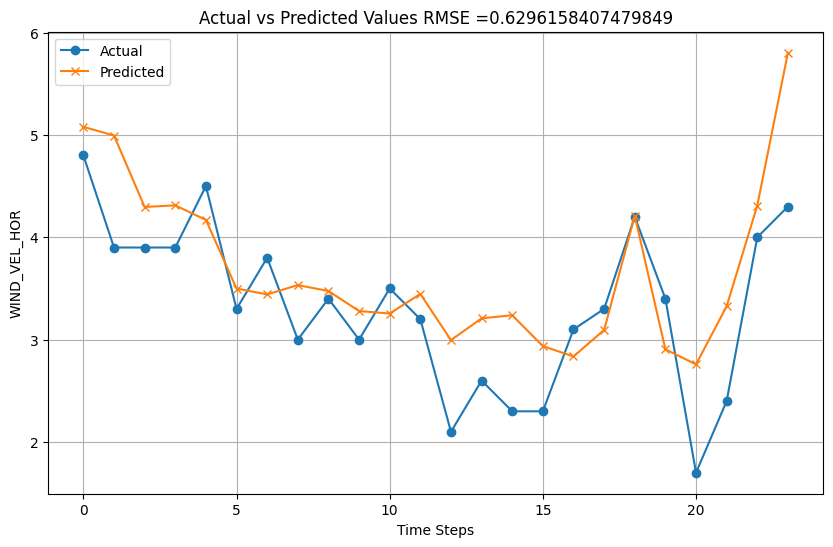

1/1 [==============================] - 0s 44ms/step


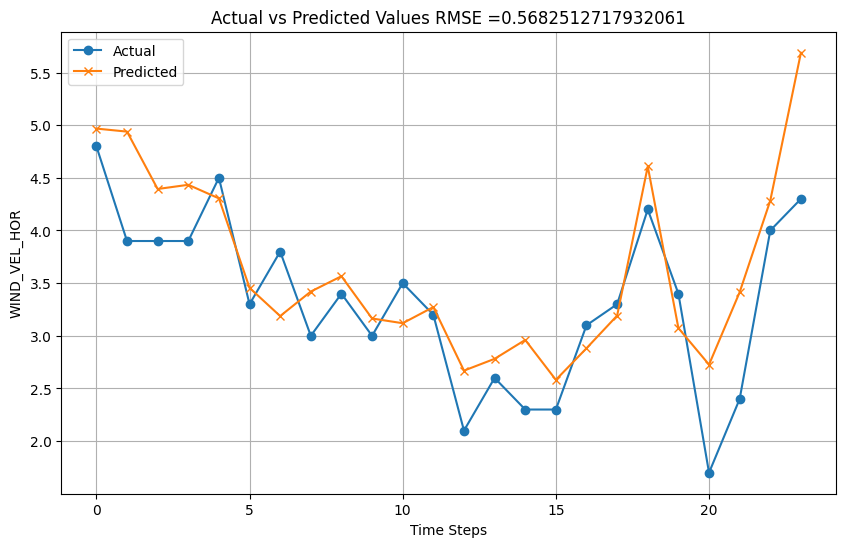

1/1 [==============================] - 0s 42ms/step


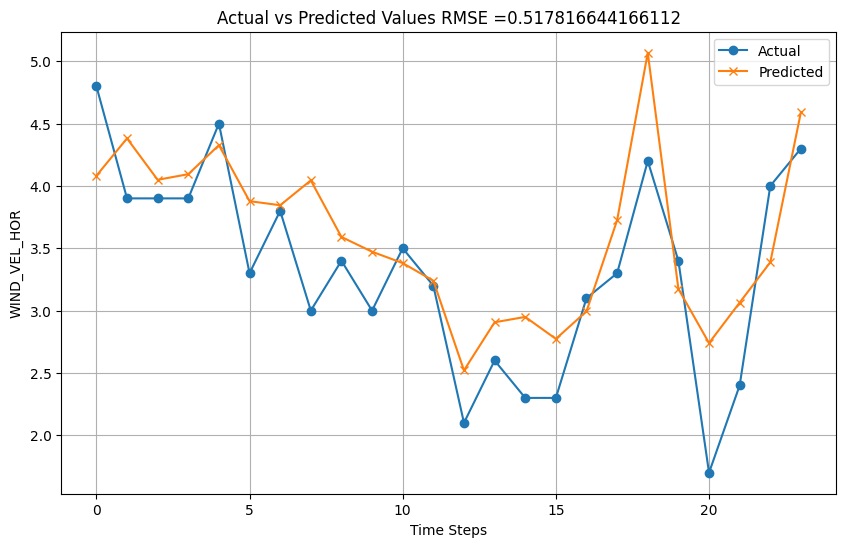

1/1 [==============================] - 0s 60ms/step


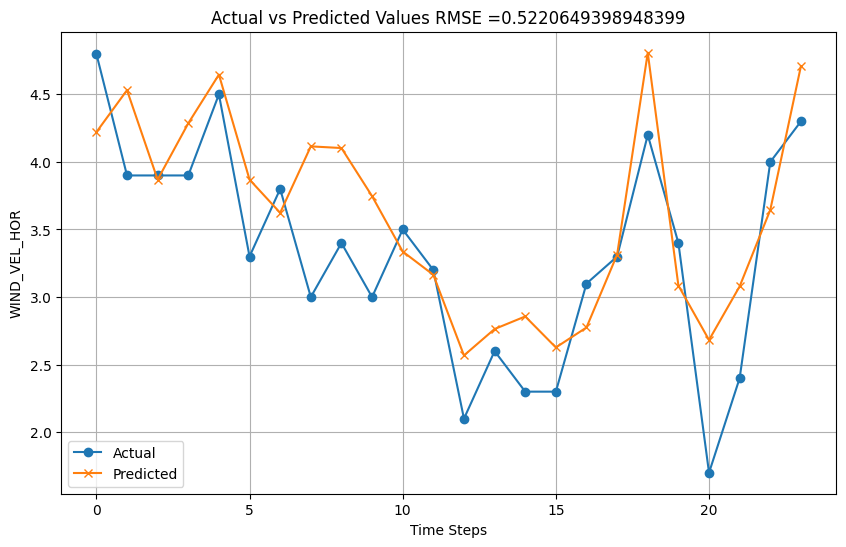

1/1 [==============================] - 0s 58ms/step


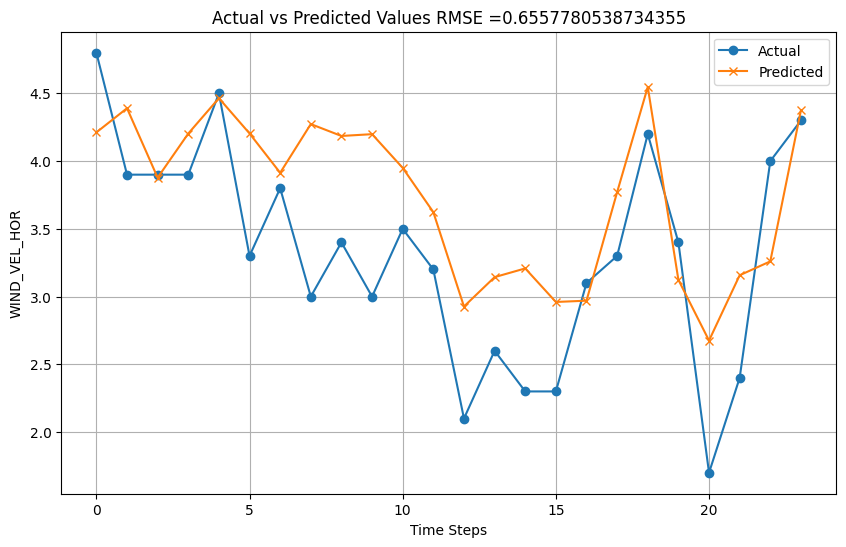

1/1 [==============================] - 0s 40ms/step


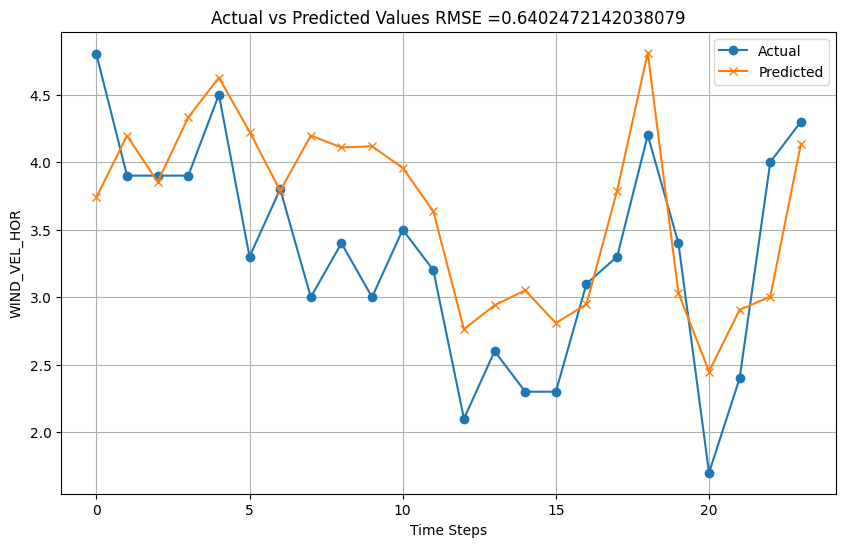

In [10]:
target_col = 'WIND_VEL_HOR'
window = 14
start = 1000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

#### Ventana de tiempo 21 días

1/1 [==============================] - 0s 39ms/step


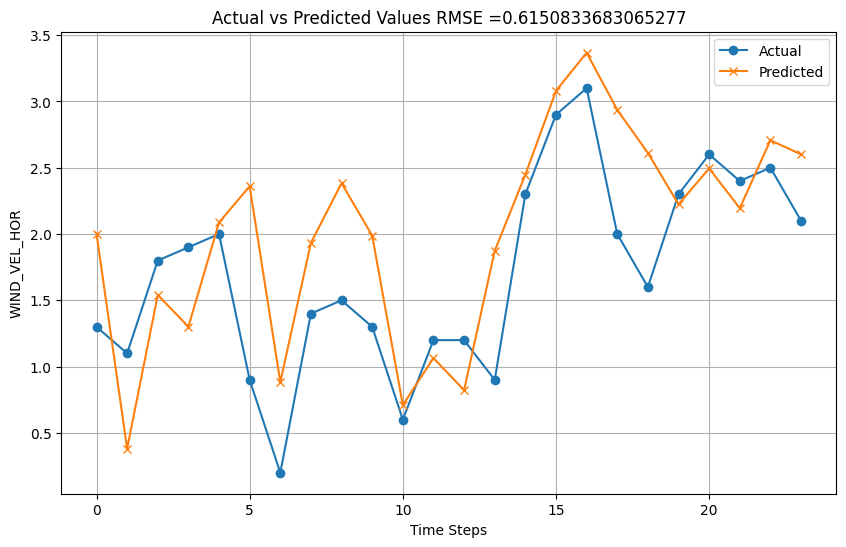

1/1 [==============================] - 0s 50ms/step


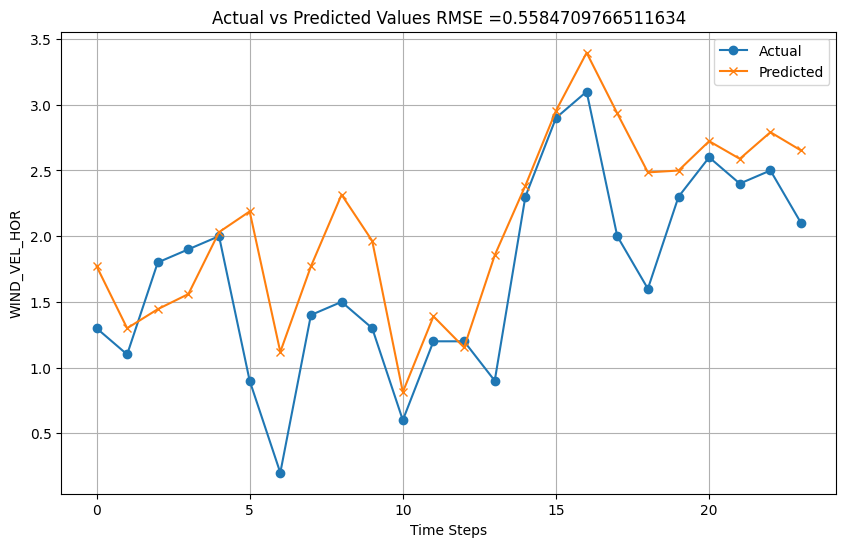

1/1 [==============================] - 0s 52ms/step


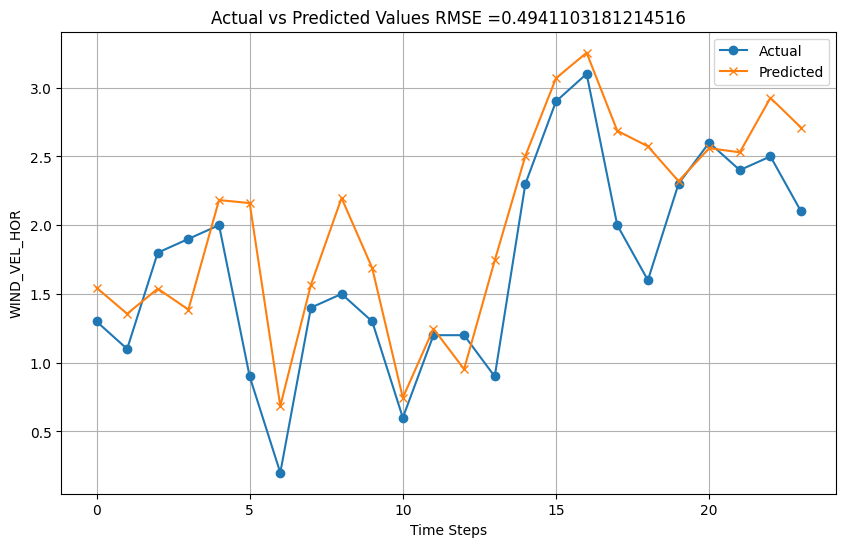

1/1 [==============================] - 0s 72ms/step


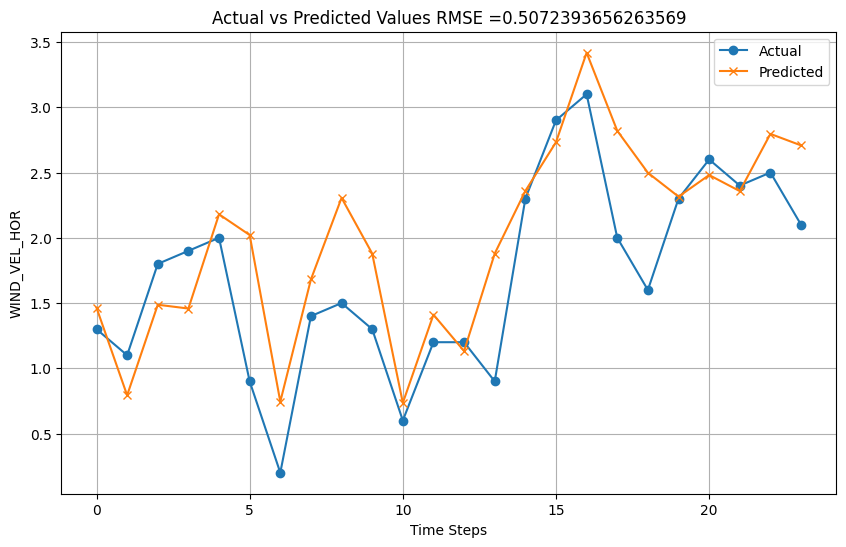

1/1 [==============================] - 0s 72ms/step


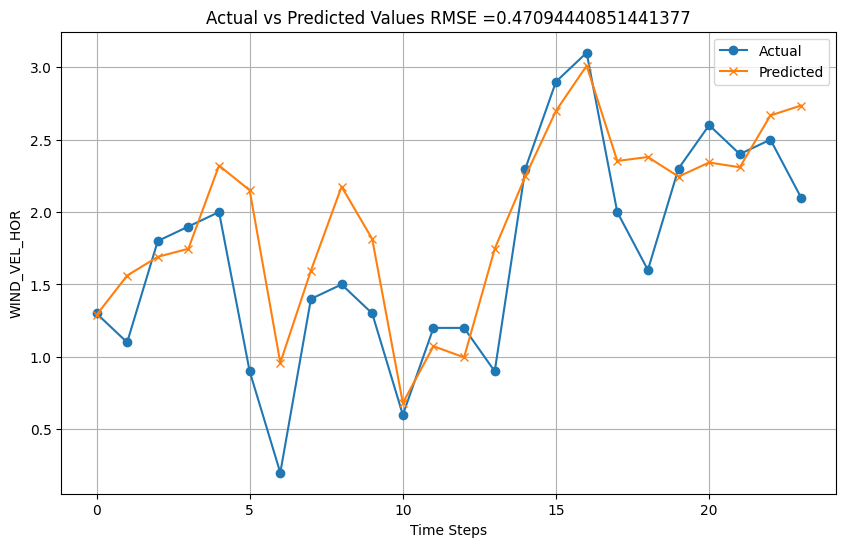

1/1 [==============================] - 0s 47ms/step


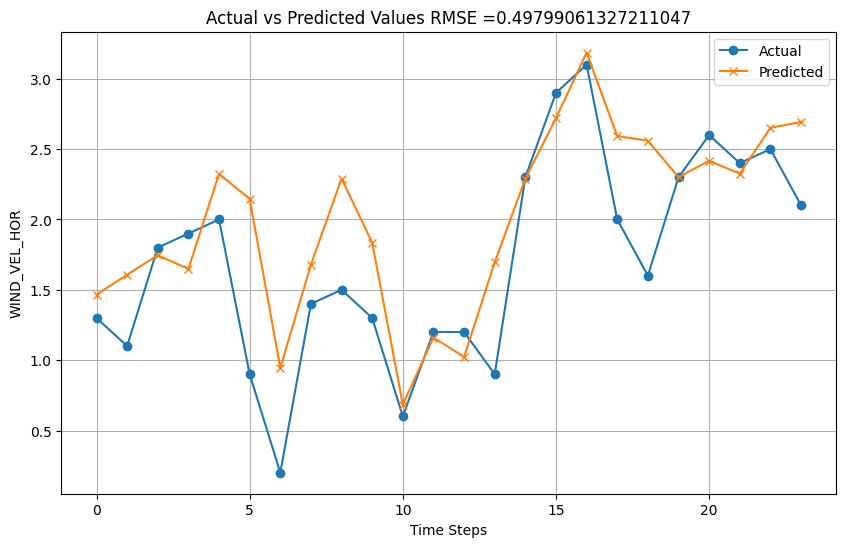

In [11]:
target_col = 'WIND_VEL_HOR'
window = 21
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()